In [ ]:
import os
import math
import time
import inspect
from dataclasses import dataclass
import torch
import torch.nn as nn
from torch.nn import functional as F
import tiktoken
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.optim.lr_scheduler import CosineAnnealingLR

In [ ]:
device = 'cpu'
if torch.cuda.is_available():
    device = 'cuda'
print(device)

cuda


In [ ]:
@dataclass
class GPTConfig:
    block_size: int = 256
    vocab_size: int = 50257
    n_layer: int = 4
    n_head: int = 6
    n_embed: int = 384
    dropout: float = 0.2


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.n_embed = config.n_embed
        self.n_head = config.n_head
        assert self.n_embed % self.n_head == 0
        # it's all 3: Q, K, V in one go for efficiency.
        self.attn = nn.Linear(self.n_embed,3*self.n_embed)
        self.w_o = nn.Linear(self.n_embed , self.n_embed)
        self.w_o.NANOGPT_SCALE_INIT = 1


        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.register_buffer("mask",torch.tril(torch.ones(config.block_size,config.block_size)).view(1,1,config.block_size,config.block_size))


    def forward(self,x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality
        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # nh is "number of heads", hs is "head size", and C (number of channels) = nh * hs
        qkv = self.attn(x)
        #splits the tensor into equal chunks, each of size split_size along the dimension dim split_size = n_embed
        q,k,v = qkv.split(self.n_embed, dim=2)
        q = q.view(B,T,self.n_head,C//self.n_head).transpose(1,2) # (B, nh, T, hs)
        k = k.view(B,T,self.n_head,C//self.n_head).transpose(1,2) # (B, nh, T, hs)
        v = v.view(B,T,self.n_head,C//self.n_head).transpose(1,2) # (B, nh, T, hs)


        att = (q @ k.transpose(-2,-1)) * (1/math.sqrt(k.size(-1)))
        att = att.masked_fill(self.mask[:, :, :T, :T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)

        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        # output projection
        y = self.w_o(y)
        y = self.resid_dropout(y)
        return y


class MLP(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.linear_1 = nn.Linear(config.n_embed , 4*config.n_embed)
        self.gelu = nn.GELU(approximate='tanh')
        self.linear_2 = nn.Linear(4*config.n_embed,config.n_embed)
        self.dropout = nn.Dropout(config.dropout)
        self.linear_2.NANOGPT_SCALE_INIT = 1

    def forward(self,x):
        x = self.linear_1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear_2(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):
    def __init__(self,config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embed)
        self.attn = MultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embed)
        self.mlp = MLP(config)

    def forward(self,x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class GPT(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embed),
            wpe = nn.Embedding(config.block_size, config.n_embed),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embed),
        ))

        self.lm_head = nn.Linear(config.n_embed, config.vocab_size, bias=False)

        # weight tying
        self.transformer.wte.weight = self.lm_head.weight

        # initialization
        self.apply(self._init_weights) #nn.Module.apply(fn) walks the entire model tree (all submodules recursively) and calls your function fn(module) on every layer.

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            std = 0.02
            if hasattr(module, 'NANOGPT_SCALE_INIT'):
                std *= (2 * self.config.n_layer) ** -0.5
            nn.init.normal_(module.weight, mean=0.0, std=std)
            if module.bias is not None:
                nn.init.zeros_(module.bias)

        elif isinstance(module, nn.Embedding):
            nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, targets=None):
        B, T = idx.size()
        assert T <= self.config.block_size , f"Cannot forward sequence of length {T}, block size is only {self.config.block_size}"
        # forward the token and posisition embeddings
        tok_emb = self.transformer.wte(idx)
        pos = torch.arange(0, T, device=idx.device)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (T, n_embd)

        x = tok_emb + pos_emb
        x = self.transformer.drop(x)

        for block in self.transformer.h:
            x = block(x)

        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)),targets.view(-1)) # # Cross entropy is applied for each token position CE_i = - log(softmax(logits[i])[ targets[i] ])
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, top_k=None):
        for _ in range(max_new_tokens):
            # crop to block size
            idx_cond = idx[:, -self.config.block_size:]

            # forward pass
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature

            # top-k filtering
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')

            probs = F.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, next_token), dim=1)
        return idx

In [ ]:
# Global tokenizer (must match vocab_size in GPTConfig)
ENCODING_NAME = "gpt2"
enc = tiktoken.get_encoding(ENCODING_NAME)

In [ ]:
def load_and_split_data(file_path, train_ratio=0.9):
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    tokens = torch.tensor(enc.encode(text), dtype=torch.long)

    n = int(train_ratio * len(tokens))
    train_tokens = tokens[:n]
    val_tokens = tokens[n:]

    print(f"Loaded {len(tokens):,} tokens | train: {len(train_tokens):,}, val: {len(val_tokens):,}")
    return train_tokens, val_tokens

In [ ]:
class GPTDataset(Dataset):
    def __init__(self, tokens, block_size):
        self.tokens = tokens
        self.block_size = block_size
        self.num_samples = (len(tokens) - 1) // block_size  # Non-overlapping

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        start = idx * self.block_size
        x = self.tokens[start : start + self.block_size]
        y = self.tokens[start + 1 : start + self.block_size + 1]
        return x, y


def create_dataloaders(train_tokens, val_tokens, block_size, batch_size):
    train_dataset = GPTDataset(train_tokens, block_size)
    val_dataset = GPTDataset(val_tokens, block_size)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

    return train_loader, val_loader

In [ ]:
@torch.no_grad()
def evaluate(model, loader, device, max_batches=None):
    model.eval()
    total_loss = 0
    for i, (x, y) in enumerate(loader):
        if max_batches and i >= max_batches:
            break
        x, y = x.to(device), y.to(device)
        _, loss = model(x, y)
        total_loss += loss.item()
    model.train()
    return total_loss / (i + 1)


def train_model(model, train_loader, val_loader, optimizer, device, epochs=5,
                eval_interval=200, save_dir="/content/drive/MyDrive/gpt_checkpoints",
                scheduler=None, max_eval_batches=50):

    os.makedirs(save_dir, exist_ok=True)
    global_step = 0
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        progress = tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}")
        for batch_idx, (x, y) in enumerate(progress):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)

            logits, loss = model(x, y)
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            global_step += 1
            progress.set_postfix({"loss": f"{loss.item():.4f}"})

            if global_step % eval_interval == 0:
                train_loss = evaluate(model, train_loader, device, max_batches=max_eval_batches)
                val_loss   = evaluate(model, val_loader, device, max_batches=max_eval_batches)
                train_losses.append(train_loss)
                val_losses.append(val_loss)

                print(f"\nStep {global_step} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

                ckpt_path = os.path.join(save_dir, f"step_{global_step}.pt")
                torch.save({
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "train_loss": train_loss,
                    "val_loss": val_loss,
                    "step": global_step
                }, ckpt_path)
                print(f"Checkpoint saved: {ckpt_path}")

    print("Training complete.")
    return train_losses, val_losses


In [ ]:
model = GPT(GPTConfig())
model.to(device)

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 384)
    (wpe): Embedding(256, 384)
    (drop): Dropout(p=0.15, inplace=False)
    (h): ModuleList(
      (0-3): 4 x Block(
        (ln_1): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (attn): MultiHeadAttention(
          (attn): Linear(in_features=384, out_features=1152, bias=True)
          (w_o): Linear(in_features=384, out_features=384, bias=True)
          (attn_dropout): Dropout(p=0.15, inplace=False)
          (resid_dropout): Dropout(p=0.15, inplace=False)
        )
        (ln_2): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
        (mlp): MLP(
          (linear_1): Linear(in_features=384, out_features=1536, bias=True)
          (gelu): GELU(approximate='tanh')
          (linear_2): Linear(in_features=1536, out_features=384, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=384, out_features=50257, bias=

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"Total parameters: {count_parameters(model):,}")

Total parameters: 26,495,616


In [ ]:
# ==== 3. Create optimizer ====
epochs = 100  #

optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95),weight_decay=0.1)

# Path to your text dataset (e.g. tiny Shakespeare)
train_tokens, val_tokens = load_and_split_data("input.txt")

# === 4. Create dataloaders ===
block_size = 256
batch_size = 64
train_loader, val_loader = create_dataloaders(train_tokens, val_tokens, block_size, batch_size)
print(f"Batches per epoch: {len(train_loader)}")

# === 5. Create scheduler ===
max_iters = epochs * len(train_loader)
warmup_iters = max_iters // 10  # 10% warmup
scheduler = CosineAnnealingLR(optimizer, T_max=max_iters, eta_min=1e-5)

# ==== 6. Train the model ====
train_losses, val_losses = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    device=device,
    epochs=epochs,  # ← Use the variable
    eval_interval=200,
    scheduler=scheduler,
    save_dir="/content/drive/MyDrive/gpt_checkpoints"
)

Loaded 338,025 tokens | train: 304,222, val: 33,803
Batches per epoch: 18


Epoch 12/100:   6%|▌         | 1/18 [00:00<00:03,  5.20it/s, loss=4.8450]


Step 200 | Train Loss: 4.8091 | Val Loss: 5.3161


Epoch 12/100:  17%|█▋        | 3/18 [00:02<00:12,  1.18it/s, loss=4.8735]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_200.pt


Epoch 23/100:  17%|█▋        | 3/18 [00:00<00:02,  5.20it/s, loss=4.0194]


Step 400 | Train Loss: 3.9867 | Val Loss: 5.0513


Epoch 23/100:  28%|██▊       | 5/18 [00:03<00:09,  1.40it/s, loss=4.0421]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_400.pt


Epoch 34/100:  28%|██▊       | 5/18 [00:01<00:02,  5.19it/s, loss=3.3217]


Step 600 | Train Loss: 3.1914 | Val Loss: 5.0767


Epoch 34/100:  39%|███▉      | 7/18 [00:03<00:07,  1.49it/s, loss=3.3392]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_600.pt


Epoch 45/100:  39%|███▉      | 7/18 [00:01<00:02,  5.19it/s, loss=2.7884]


Step 800 | Train Loss: 2.4341 | Val Loss: 5.4111


Epoch 45/100:  50%|█████     | 9/18 [00:03<00:05,  1.57it/s, loss=2.8355]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_800.pt


Epoch 56/100:  50%|█████     | 9/18 [00:01<00:01,  5.19it/s, loss=2.2985]


Step 1000 | Train Loss: 1.7927 | Val Loss: 5.6781


Epoch 56/100:  61%|██████    | 11/18 [00:04<00:04,  1.62it/s, loss=2.2523]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_1000.pt


Epoch 67/100:  61%|██████    | 11/18 [00:02<00:01,  5.18it/s, loss=1.8558]


Step 1200 | Train Loss: 1.3578 | Val Loss: 5.9536


Epoch 67/100:  72%|███████▏  | 13/18 [00:04<00:03,  1.62it/s, loss=1.9157]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_1200.pt


Epoch 78/100:  72%|███████▏  | 13/18 [00:02<00:00,  5.18it/s, loss=1.5912]


Step 1400 | Train Loss: 1.1023 | Val Loss: 6.1341


Epoch 78/100:  83%|████████▎ | 15/18 [00:04<00:01,  1.63it/s, loss=1.6243]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_1400.pt


Epoch 89/100:  83%|████████▎ | 15/18 [00:03<00:00,  5.18it/s, loss=1.5177]


Step 1600 | Train Loss: 0.9809 | Val Loss: 6.2199


Epoch 89/100:  94%|█████████▍| 17/18 [00:05<00:00,  1.63it/s, loss=1.5368]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_1600.pt


Epoch 100/100:  94%|█████████▍| 17/18 [00:03<00:00,  5.18it/s, loss=1.4519]


Step 1800 | Train Loss: 0.9431 | Val Loss: 6.2448


Epoch 100/100: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s, loss=1.4519]

Checkpoint saved: /content/drive/MyDrive/gpt_checkpoints/step_1800.pt
Training complete.


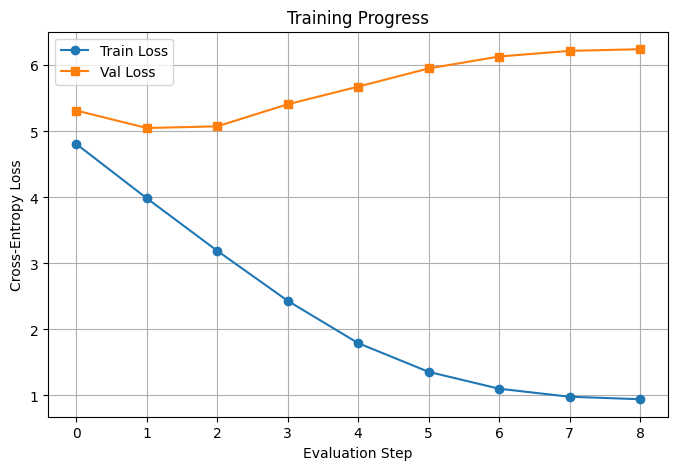

In [ ]:

plt.figure(figsize=(8,5))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(val_losses, label="Val Loss", marker='s')
plt.title("Training Progress")
plt.xlabel("Evaluation Step")
plt.ylabel("Cross-Entropy Loss")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.eval()
prompt = "ROMEO:"
tokens = torch.tensor(enc.encode(prompt), dtype=torch.long).unsqueeze(0).to(device) # # [18, 24, 22, 10, 24, 26]  (example token IDs) # # Shape: idx = [1, 6]
generated = model.generate(tokens, max_new_tokens=100, temperature=0.8, top_k=40)
print(enc.decode(generated[0].tolist()))

ROMEO:
A thousand times the night,
From whom I have not another sound to say.

HENRY BOLINGBROKE:
The ere the king disinheritied dust.

HENRY BOLINGBROKE:
I know not yet did not I have done,
I see your father's face shall be.

HENRY BOLINGBROKE:
Be patient as I.

HENRY B
